Code for implementing our CNN Model

Contributors-

1. Vaibhav Chhabra

2. Vishwanath Hurakadli

In [ ]:
import numpy as np
import os

In [ ]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.io import read_image
from torch.utils.data import DataLoader
from sklearn.utils import shuffle
import torch.optim as optim
from torchsummary import summary

In [ ]:
Transform = transforms.Compose([transforms.ToTensor(), transforms.Resize(224)])
train_set = datasets.ImageFolder('dataset/train', transform=Transform)
test_set = datasets.ImageFolder('dataset/test', transform=Transform)

In [ ]:
train_set = shuffle(train_set)
test_set = shuffle(test_set)

In [ ]:
words = ['Begin', 'Choose', 'Connection', 'Navigation', 'Next', 'Previous', 'Start', 'Stop', 'Hello', 'Web']

Label: Next


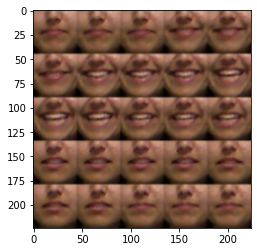

In [ ]:
plt.imshow(train_set[0][0].permute(1, 2, 0))
print("Label:", words[train_set[0][1]])

In [ ]:
class Model1(nn.Module):
  def __init__(self):
    super(Model1, self).__init__()
    self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
    self.conv1_2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

    self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

    self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
    
    self.relu = nn.ReLU()

    self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

    self.bn1 = nn.BatchNorm1d(50176)
    self.dropout1 = nn.Dropout(p = 0.5)
    self.fc1 = nn.Linear(50176, 4096)
    self.bn2 = nn.BatchNorm1d(4096)
    self.dropout2 = nn.Dropout(p = 0.3)
    self.fc2 = nn.Linear(4096, 10)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, output):
    # input shape - (b_size, 224, 224, 3)
    output = self.conv1_1(output) # shape - (b_size, 224, 224, 32)
    output = self.relu(output) # shape - (b_size, 224, 224, 32)
    output = self.conv1_2(output) # shape - (b_size, 224, 224, 64)
    output = self.relu(output) # shape - (b_size, 224, 224, 64)
    output = self.maxpool(output) # shape - (b_size, 112, 112, 64)
    output = self.conv2(output) # shape - (b_size, 112, 112, 64)
    output = self.relu(output) # shape - (b_size, 112, 112, 64)
    output = self.maxpool(output) # shape - (b_size, 56, 56, 64)
    output = self.conv3(output) # shape - (b_size, 56, 56, 64)
    output = self.relu(output) # shape - (b_size, 56, 56, 64)
    output = self.maxpool(output) # shape - (b_size, 28, 28, 64)

    # Flattening
    output = output.view(-1, 28*28*64) # shape - (b_size, 50176)
    output = self.bn1(output) # shape - (b_size, 50176) # Applying Batch normalisation
    output = self.dropout1(output) # shape - (b_size, 50176) # Applying Dropout
    output = self.fc1(output) # shape - (b_size, 4096)
    output = self.bn2(output) # shape - (b_size, 4096) # Applying Batch normalisation
    output = self.dropout2(output) # shape - (b_size, 4096) # Applying Dropout
    output = self.relu(output) # shape - (b_size, 4096)
    output = self.fc2(output) # shape - (b_size, 10)
    output = self.softmax(output) # shape - (b_size, 10)
    return output

net = Model1()
summary(net, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU-2         [-1, 32, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          18,496
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6         [-1, 64, 112, 112]          36,928
              ReLU-7         [-1, 64, 112, 112]               0
         MaxPool2d-8           [-1, 64, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          36,928
             ReLU-10           [-1, 64, 56, 56]               0
        MaxPool2d-11           [-1, 64, 28, 28]               0
      BatchNorm1d-12                [-1, 50176]         100,352
          Dropout-13                [-1, 50176]               0
           Linear-14                 [-

In [ ]:
num_epochs = 25
num_classes = 10
lr = 0.001
rho = 0.9
b_size = 50

ce = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(net.parameters(), lr = lr, alpha = rho)

In [ ]:
trainDataLoader = DataLoader(train_set, shuffle = True, batch_size = b_size)
testDataLoader = DataLoader(test_set, shuffle = True, batch_size = b_size)

In [ ]:
def Train(trainDataLoader, testDataLoader, net, num_epochs, b_size, num_classes, optimizer):
  epoch_loss = np.zeros(num_epochs)
  epoch_loss_test = np.zeros(num_epochs)

  train_acc = np.zeros(num_epochs)
  test_acc = np.zeros(num_epochs)

  for I in range(num_epochs):

    print("Epoch[",I+1,"] started...")

    right_count = 0
    right_count_test = 0

    total_count = len(trainDataLoader)*b_size
    total_count_test = len(testDataLoader)*b_size

    for batch_idx, (data, targets) in enumerate(trainDataLoader):
      
      print("Processing Batch[",batch_idx+1,"]")

      # Forward
      output = net(data)
      loss = ce(output, targets)
      epoch_loss[I] += float(loss)
      
      # Backward
      optimizer.zero_grad()
      loss.backward()
      
      # Optimizing step
      optimizer.step()

      # calculating training accuracy
      for a in range(b_size):
        idx = torch.argmax(output[a])
        if(targets[a] == idx):
          right_count += 1

    # Testing
    print("Now Testing...")
    for batch_idx, (data, targets) in enumerate(testDataLoader):
      # targets_arr = np.zeros((b_size, num_classes))
      # for i in range(b_size):
      #   targets_arr[i][targets[i]] = 1
      # targets_arr = torch.tensor(targets_arr)
      
      pred = net(data)
      loss = ce(pred, targets)
      epoch_loss_test[I] += float(loss)

       # calculating testing accuracy
      for a in range(b_size):
        idx = torch.argmax(pred[a])
        if(targets[a] == idx):
          right_count_test += 1
    
    train_acc[I] = right_count/total_count*100
    test_acc[I] = right_count_test/total_count_test*100
    print('Epoch[', I+1, '/', num_epochs,'] :', 'Train Accuracy =', train_acc[I], '  , Test Accuracy =', test_acc[I])
    
  fig = plt.figure(figsize=(16, 6))

  # Plotting Training and Testing Error
  fig.add_subplot(1, 2, 1)

  plt.plot(epoch_loss, label='Train')
  plt.plot(epoch_loss_test, label='Test')
  plt.xlabel('Epochs')
  plt.ylabel('Error')
  plt.legend()

  # Plotting Training and Testing Accuracy
  fig.add_subplot(1, 2, 2)

  plt.plot(train_acc, label='Train')
  plt.plot(test_acc, label='Test')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

Epoch[ 1 ] started...
Processing Batch[ 1 ]
Processing Batch[ 2 ]
Processing Batch[ 3 ]
Processing Batch[ 4 ]
Processing Batch[ 5 ]
Processing Batch[ 6 ]
Processing Batch[ 7 ]
Processing Batch[ 8 ]
Processing Batch[ 9 ]
Processing Batch[ 10 ]
Processing Batch[ 11 ]
Processing Batch[ 12 ]
Processing Batch[ 13 ]
Processing Batch[ 14 ]
Processing Batch[ 15 ]
Processing Batch[ 16 ]
Processing Batch[ 17 ]
Processing Batch[ 18 ]
Processing Batch[ 19 ]
Processing Batch[ 20 ]
Processing Batch[ 21 ]
Now Testing...
Epoch[ 1 / 25 ] : Train Accuracy = 21.619047619047617   , Test Accuracy = 25.333333333333336
Epoch[ 2 ] started...
Processing Batch[ 1 ]
Processing Batch[ 2 ]
Processing Batch[ 3 ]
Processing Batch[ 4 ]
Processing Batch[ 5 ]
Processing Batch[ 6 ]
Processing Batch[ 7 ]
Processing Batch[ 8 ]
Processing Batch[ 9 ]
Processing Batch[ 10 ]
Processing Batch[ 11 ]
Processing Batch[ 12 ]
Processing Batch[ 13 ]
Processing Batch[ 14 ]
Processing Batch[ 15 ]
Processing Batch[ 16 ]
Processing Batc

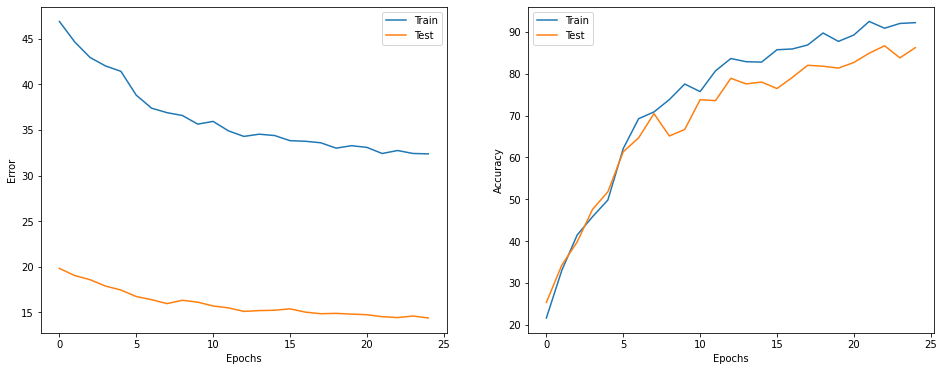

In [ ]:
Train(trainDataLoader, testDataLoader, net, num_epochs, b_size, num_classes, optimizer)